In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
fpa_data = np.genfromtxt('fpa.dat', delimiter='     ')
ascending_data = np.genfromtxt('ascending_data.dat', delimiter='    ')

## Question 1

Now, bidders draw cost $c_i$ from cdf $F(\cdot)$ and get payoff $(b_i-c_i)$. In order to derive the symmetryic Nash equilibrium bidding strategy we use the revelation principle to restrict attention to direct mechanisms where participants only report $v_i$. Now we must compute $b(c)$, the bid corresponding to $c_i$. We know that firms make expected profits

$$\pi(v_i, b_i,F(\cdot)) = (b(c) - c)(1-F(c))^{i-1}$$

The necessary first order condition with respect to $c$ when $c = c_i$

$$\dfrac{\partial }{\partial c}b(c)(1-F(c))^{i-1} = \dfrac{\partial}{\partial c}c(1-F(c))^{i-1}  $$

Integrating from $\bar{c}$ to $c_i$ (making use of the corner condition $\bar{c} = b(\bar{c})$) we have that

$$b(c_i)(1-F(c_i))^{i-1} - \bar{c}(1-F(\bar{c}))^{i-1}  = \int_{\bar{c}}^{c_i} c (1-F(c))^{i-1} dc $$

Integrating by parts we get that

$$b(c_i)(1-F(c_i))^{i-1} = c_i (1-F(c_i))^{i-1} - \int^{c_i}_{\bar{c}}(1-F(c))^{i-1} dc $$

Dividing through by $(1-F(c_i))^{i-1}$ and flipping the limits of integration (to emphasize that the markup is positive) we get the usual formula

$$b(c_i) = c_i + \int^{\bar{c}}_{c_i}\dfrac{(1-F(c))^{i-1}}{(1-F(c_i))^{i-1}} dc $$



## Question 2

### Part A- B

$G^i(m|b)$

$v_i = b_i + \dfrac{G^i_{mb}(b,b)}{g^i_{mb}(b,b)}$

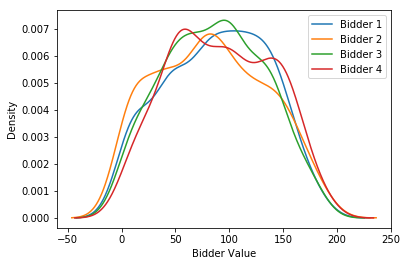

In [3]:

def apv_helper(data,i):
    """calculate the amount of shadding at each bid"""
    #calc bandwith
    T, n = data.shape
    sigma = data.var(axis=0)[i]
    h = 2.98*1.06*sigma*T**(-1/5) #use silverman bandwith
    
    #set up data
    support = data[:,i]
    support.sort()
    bt = np.repeat(support,T)
    bs = np.tile(data[:,i], T)
    ms = np.tile(data.max(axis=1),T)

    #caluclate formula inside the sum
    kernel1 = stats.norm.pdf( (bt - bs)/h ) #Guassian Kernel
    kernel2 = stats.norm.pdf( (bt - ms)/h )
    ind = ms <= bt
    
    cdf = (kernel1*ind).reshape(T,T)
    cdf = cdf.sum(axis=1)/(T*h)
    pdf = (kernel1*kernel2).reshape(T,T)
    pdf =  pdf.sum(axis=1)/(T*h**2)
    return support + cdf/pdf
    
marginals = []
apv_values = []

for i in range(4):
    v = apv_helper(fpa_data,i) 
    apv_values.append(v)
    
    kde = sm.nonparametric.KDEUnivariate(v)
    kde.fit()
    marginals.append(kde)
    
    plt.plot(kde.support, kde.density, label='Bidder %s'%(i+1) )
    
plt.legend()
plt.xlabel('Bidder Value')
plt.ylabel('Density')
plt.show()

### Part C

In [4]:
def enum_vectors(quantiles,n):
    """recursively enumerate all the quantiles"""
    if n == 1:
        vectors = []
        for q in quantiles:
            vectors.append([q])
        return vectors
    if n > 1:
        vectors = enum_vectors(quantiles,n-1)
        new_vectors = []
        for q in quantiles:
            for v in vectors:
                new_vectors.append(v + [q])
        return new_vectors
        

In [5]:
kde_mv = sm.nonparametric.KDEMultivariate(np.array(apv_values).transpose(),['c','c','c','c'])
vectors = enum_vectors([.25,.75],4)

for v in vectors:
    inverse_v = []
    for i in range(4):
        index = (marginals[i].cdf <= v[i]).sum()
        inverse_v.append( marginals[i].support[index] )
    print '==============================================================================================='
    print ' Quantile: %s | Values: %s | CDF %s'%(v, np.round(inverse_v,2) ,np.round(kde_mv.cdf(inverse_v),2))

 Quantile: [0.25, 0.25, 0.25, 0.25] | Values: [50.78 41.22 50.25 53.79] | CDF 0.12
 Quantile: [0.75, 0.25, 0.25, 0.25] | Values: [127.42  41.22  50.25  53.79] | CDF 0.14
 Quantile: [0.25, 0.75, 0.25, 0.25] | Values: [ 50.78 124.24  50.25  53.79] | CDF 0.15
 Quantile: [0.75, 0.75, 0.25, 0.25] | Values: [127.42 124.24  50.25  53.79] | CDF 0.18
 Quantile: [0.25, 0.25, 0.75, 0.25] | Values: [ 50.78  41.22 122.97  53.79] | CDF 0.14
 Quantile: [0.75, 0.25, 0.75, 0.25] | Values: [127.42  41.22 122.97  53.79] | CDF 0.18
 Quantile: [0.25, 0.75, 0.75, 0.25] | Values: [ 50.78 124.24 122.97  53.79] | CDF 0.18
 Quantile: [0.75, 0.75, 0.75, 0.25] | Values: [127.42 124.24 122.97  53.79] | CDF 0.26
 Quantile: [0.25, 0.25, 0.25, 0.75] | Values: [ 50.78  41.22  50.25 133.1 ] | CDF 0.15
 Quantile: [0.75, 0.25, 0.25, 0.75] | Values: [127.42  41.22  50.25 133.1 ] | CDF 0.18
 Quantile: [0.25, 0.75, 0.25, 0.75] | Values: [ 50.78 124.24  50.25 133.1 ] | CDF 0.18
 Quantile: [0.75, 0.75, 0.25, 0.75] | Values: [

### Part D

### Part E

### Part F

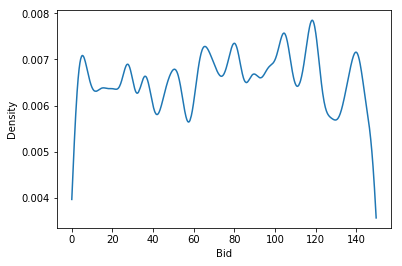

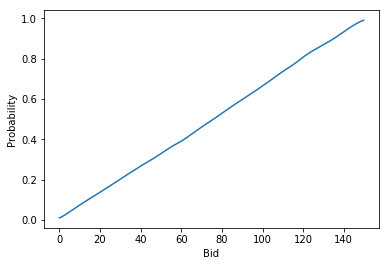

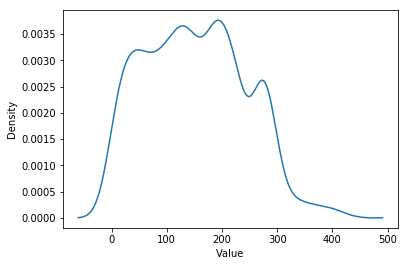

In [20]:
#KDE to estimate the distribution of bids
def ipv_helper(data):
    T, n = data.shape
    
    #calc bandwith
    sigma = data.var(axis=0)[i]
    h = 2.98*1.06*sigma*(T*n)**(-1/5) #use silverman bandwith
    
    #set up data
    support =  data.reshape(T*n)
    support.sort()
    
    bt = np.repeat(support,T*n)
    bs = np.tile(data.reshape(T*n), T*n)

    #caluclate formula inside the sum
    pdf = stats.norm.pdf( (bt - bs)/h ) #Guassian Kernel
    pdf = pdf.reshape(T*n,T*n)
    pdf =  pdf.sum(axis=1)/(T*h*n)
    
    #plot
    plt.plot(support, pdf )
    plt.xlabel('Bid')
    plt.ylabel('Density')
    plt.show()
    
    cdf = stats.norm.cdf( (bt - bs)/h )
    cdf = (cdf).reshape(T*n,T*n)
    cdf = cdf.sum(axis=1)/(n*T)
    
    #plot
    plt.plot(support, cdf )
    plt.xlabel('Bid')
    plt.ylabel('Probability')
    plt.show()
    
    return support + cdf/pdf
    
ipv_values = ipv_helper(fpa_data) 
kde = sm.nonparametric.KDEUnivariate(ipv_values)
kde.fit()

plt.xlabel('Value')
plt.ylabel('Density')
plt.plot(kde.support, kde.density )
plt.show()

## Question 3

In [71]:
print math.factorial(2-1)

1


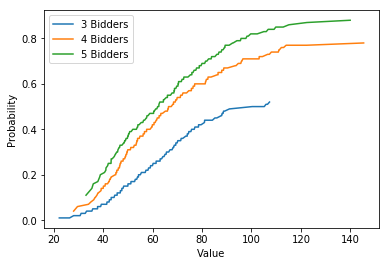

In [103]:
from scipy.optimize import fsolve

def calc_phi(cdf,n):
    #calculate integral and solve using reimann sum
    steps = cdf.shape[0]
    t = np.arange(0,1,.01)
    integral = n*(n-1)*((1-t)*t**(n-2))
    
    phi = []
    step = 1
    for h in cdf:
        
        diff = abs(h - integral[0:step].mean())
        new_diff = abs(h - integral[0:step+1].mean())

        while (diff >= new_diff):
            step = step + 1
            diff = abs(h - integral[0:step].mean())
            new_diff = abs(h - integral[0:step+1].mean())
        
        phi.append(step*.01)

    return phi
    
    



#plot the values implied by the order statistic
ns, supps, cdfs = english_helper(ascending_data)
for i in range(int(ns[-1] - ns[0]+1)):
    value = calc_phi(cdfs[i], ns[i])
    #plt.plot(supps[i], cdfs[i] , label = '%s Order'%int(ns[i]))
    plt.plot(supps[i], value , label = '%s Bidders'%int(ns[i]))
    
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
def english_helper(data):
    #calculate empirical cdf
    ns = np.arange( data[:,0].min(),data[:,0].max()+1,1)

    cdfs = []
    supps = []
    for n in ns:
        support = data[:,1][data[:,0]==n]
        support, bids = support.copy(), support.copy()
        support.sort()
        supps.append(support)
        
        T = support.shape[0]

        bt = np.repeat(support,T)
        bs = np.tile(bids, T)

        pdf = 1.*(bt >= bs)
        pdf = pdf.reshape(T,T)
        pdf =  pdf.sum(axis=1)/(T)
        cdfs.append(pdf)
        
    return ns, supps, cdfs